In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
from pysurvival.models import BaseModel
from pysurvival import utils
import scipy
import pandas as pandas
import copy
import random
from sklearn.preprocessing import StandardScaler
from source.utils import create_correlated_var
from pysurvival.models.simulations import SimulationModel
from lifelines import CoxPHFitter
import pandas as pd
from sklearn.model_selection import train_test_split
import networkx as nx
from cga import cga
from itertools import cycle
import tqdm as tqdm
import matplotlib.pyplot as plt

In [4]:
from typing import Optional, Callable, TypeVar

## Helper Functions

In [5]:
def fit_coxph(df):
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()

def fit_coxph_norm(df):
    standard_scaler = StandardScaler()
    for col in df.columns:
        if col == 'time' or col == 'event':
            pass
        df[col] = standard_scaler.fit_transform(df[[col]])
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()


def save_orig(df, name, output_dir):
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )
    print(f"Saved {output_dir}/{name}_train.csv")
    print(f"Saved {output_dir}/{name}_valid.csv")

def df2csv(
        df: pd.DataFrame,
        name: str,
        output_dir: str,
):
    """
    Writes csv given a dataframe + name
    """
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train_details.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid_details.csv",
        index=False,
    )

    train_df = train.loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]
    valid_df = valid.loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]
    train_df.rename(columns=dict(x_orig='x',
                                 y_orig='y',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)

    valid_df.rename(columns=dict(x_orig='x',
                                 y_orig='y',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)
    train_df.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid_df.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )

## Simulation Model with correlations

In [6]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      include_hazard: bool = False
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights )

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)


            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        BX = risk_function(X_std, feature_weights)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        if include_hazard:
            self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

## Correlation Case Graph

In [3]:
@cga.node
def correlate(x: float, rnorm_vector:float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = create_correlated_var(x, rnorm_vector,
                                      mu=np.mean(x),
                                      sd=np.std(x),
                                      empirical=True,
                                      r=0.00)
    return correlate + noise

@cga.node
def sample_random_normal(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal(size=100) + noise

@cga.node
def correlation_coefficient(coeff:float) -> float:
    return coeff

class CorrelationCaseGraph(cga.Graph):
    def __init__(self):
        """
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        noise = cga.node(lambda: np.random.normal(scale=0.1, size=100))
        rnorm_vector = cga.node(lambda: np.random.normal(size=100))
        self.rnorm = rnorm_vector(name="rnorm")
        self.noise_x = noise(name="noise_x")
        self.noise_y = noise(name="noise_y")
        self.x = sample_random_normal(self.noise_x, name='x')
        self.y = correlate(self.x, self.rnorm, self.noise_y, name='y')
        super().__init__([self.x, self.y])

    def get_interventions(self,
                          sim: SimulationModelWithCorrelations,
                          n_iterations: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = None
        for node in [self.noise_x, self.noise_y]:
            for _ in tqdm.trange(n_iterations, desc=f"Intervention {node.name}"):
                # resample noise
                orig, interventions, *_ = self.sample_do(action=cga.Resample(node), n_samples=100)
                row = {'modified_attribute': [node.name] * 100}
                # add orig + do to the dictionary
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})

                data = row if data is None else data
                for key in row.keys():
                    row[key] = row[key].tolist() if isinstance(row[key], np.ndarray) else row[key]
                    data[key].extend(row[key])
        df = pd.DataFrame(data)

        orig_cols = ['x_orig', 'y_orig']
        orig_df = sim.generate_data(df, feature_names=orig_cols,
                                    feature_weights=feature_weights,
                                    include_hazard=True)

        # split by modified attribute, to get the input data for attribution
        xdf = orig_df.loc[orig_df.modified_attribute=='noise_x']\
            .loc[:, ['x_orig', 'y_orig', 'time', 'event']]\
            .rename(columns=dict(x_orig='x', y_orig='y'))
        ydf = orig_df.loc[orig_df.modified_attribute=='noise_y']\
            .loc[:, ['x_orig', 'y_orig', 'time', 'event']]\
            .rename(columns=dict(x_orig='x', y_orig='y'))

        df['hazard_orig'] = orig_df.hazard
        df['event_orig'] = orig_df.event
        df['time_orig'] = orig_df.time

        return xdf, ydf, df

    def test_intervention(self, n_iterations):
        for node in [self.noise_x]:
            for _ in tqdm.trange(n_iterations, desc=f"Intervention {node.name}"):
                # resample noise
                orig, intervention0, intervention1 = self.sample_do(action=cga.Resample(node))
        return orig, intervention0, intervention1

NameError: name 'SimulationModelWithCorrelations' is not defined

## Sample from Graph

In [107]:
# Sample features
data = None
correlation_graph = CorrelationCaseGraph()
for _ in tqdm.trange(100, desc='sampling'):
    result = correlation_graph.sample()
    data = result if data is None else data
    for key in result.keys():
        result[key] = result[key].tolist() if isinstance(result[key], np.ndarray) else result[key]
        data[key].extend(result[key])
del data[correlation_graph.noise_x]
del data[correlation_graph.noise_y]
del data[correlation_graph.rnorm]

# Generate data
training_features = pd.DataFrame(data)
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=5.0, censored_parameter=5.0, survival_distribution='weibull')
feature_weights = [np.log(2), np.log(1.5)]
feature_names = [correlation_graph.x, correlation_graph.y]
training_df = sim.generate_data(training_features, feature_weights=feature_weights, feature_names=feature_names)

# Check correlations
training_df.corr()

sampling: 100%|██████████| 100/100 [00:00<00:00, 517.00it/s]


Number of data-points: 10100 - Number of events: 7966.0


,x,y,time,event
x,1.000000,0.009877,-0.252497,0.003748
y,0.009877,1.000000,-0.138685,0.015104
time,-0.252497,-0.138685,1.000000,0.780548
event,0.003748,0.015104,0.780548,1.000000


## Save Training Data

In [108]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
save_orig(training_df, name='p0.00', output_dir=directory)

Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/p0.00_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/p0.00_valid.csv


## Resample Features

In [109]:
# Resample from graph
correlation_graph = CorrelationCaseGraph()
feature_weights = [np.log(2), np.log(1.5)]
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=5.0, censored_parameter=5.0, survival_distribution='weibull')
xdf, ydf, attribute_df = correlation_graph.get_interventions(sim=sim, n_iterations=50, feature_weights=feature_weights)

Intervention noise_y: 100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Number of data-points: 10100 - Number of events: 7988.0


## Save Attribution Data

In [110]:
xdf.to_csv(f'{directory}/p0.00_attribute_x.csv', index=False)
ydf.to_csv(f'{directory}/p0.00_attribute_y.csv', index=False)
attribute_df.to_csv(f'{directory}/p0.00_attribute_details.csv', index=False)

# Simpsons Paradox Graph

In [112]:
def get_simpsons_paradox(
        p: float = 2,
        q: float = 1,
        n: float = 500,
        n_groups: int = 5,
):

    k = np.random.choice(5, size=n)
    scaling = np.random.normal(size=n)

    noise_x = np.random.normal(scale=0.25, size=n)
    noise_y = np.random.normal(scale=0.25, size=n)
    y = scaling * np.sin(p / q) + k + noise_y
    x = scaling * np.cos(p / q) + k + noise_x
    return x, y


T = TypeVar("T")


def ifnone(maybe: Optional[T], default: T) -> T:
    if maybe is None:
        return default
    else:
        return maybe


@cga.node
def simpson_x(
        scaling: float,
        group: float,
        noise: float,
) -> float:
    return scaling * np.cos(2 / 1) + group + noise


@cga.node
def simpson_y(
        scaling: float,
        group: float,
        noise: float,
) -> float:
    return scaling * np.sin(2 / 1) + group + noise


@cga.node
def simpson_hazzard(
        scaling: float,
        group: float,
) -> float:
    return np.where(group == 2, scaling, -scaling).item()


class SimpsonsParadoxGraph(cga.Graph):
    def __init__(self):
        # define functions
        noise = cga.node(lambda: np.random.normal(scale=0.27))
        get_group = cga.node(lambda: np.random.choice(5))
        get_scaling = cga.node(lambda: np.random.normal())

        self.noise_x = noise(name="noise_x")
        self.noise_y = noise(name="noise_y")
        self.group = get_group(name="group")

        self.scaling = get_scaling(name="scaling")

        self.x = simpson_x(self.scaling, self.group, self.noise_x, name="x")
        self.y = simpson_y(self.scaling, self.group, self.noise_y, name="y")

        self.hazzard = simpson_hazzard(self.scaling, self.group, name="hazzard")
        super().__init__([self.x, self.y, self.hazzard])

    def get_interventions(self, g, sim, n_samples):
        data = []
        for node in [g.noise_x, g.noise_y]:
            for _ in tqdm.auto.trange(n_samples,
                                      desc=f"Intervention {node.name}"):
                orig, interventions = g.sample_do(
                    action=cga.Resample(node),
                    n_samples=100,
                )
                row = {'modified_attribute': node.name}
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                for idx, intervention in enumerate(interventions):
                    row.update({
                        n.name + f"_intervention{idx}": v
                        for n, v in intervention.items()})
                data.append(row)
            df = pd.DataFrame(data)
        sim_df = sim.generate_data(df, hazzard_column='hazzard_orig')
        df['event_orig'] = sim_df.event
        df['time_orig'] = sim_df.time

        # separate x and y to build attribute dataframe
        xdf = df.loc[df.modified_attribute=='noise_x']\
                  .loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]\
            .rename(columns=dict(x_orig='x', y_orig='y', time_orig='time', event_orig='event'))
        ydf = df.loc[df.modified_attribute=='noise_y']\
                  .loc[:, ['x_orig', 'y_orig', 'time_orig', 'event_orig']]\
            .rename(columns=dict(x_orig='x', y_orig='y', time_orig='time', event_orig='event'))

        return xdf, ydf, df


    def transform(
            self,
            dataset_row: pd.Series,
            set_values: dict = {},
            replace_nodes: dict = {},
    ) -> pd.Series:
        # print(dataset_row.keys())
        result = self.sample(
            set_values={
                self.scaling: dataset_row["predictive0"],
                self.group: np.digitize(
                    dataset_row["nonpredictive0"], [-1.5, -1, 0, 1, 1.5]
                ),
            },
            replace=replace_nodes,
        )
        return pd.Series(
            index=["x", "y", "event", "time"],
            data=[
                result[self.x],
                result[self.y],
                dataset_row["event"],
                dataset_row["time"],
            ],
        )

## Simulation Model with Risk

In [113]:
class SimulationModelWithRisk(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(
            self,
            dataframe: pd.DataFrame,
            hazzard_column="hazzard",
    ):
        """
        Generating a dataset of simulated survival times from a given
        distribution through the hazard function using the Cox model

        Parameters:
        -----------

        * `dataframe`: **pd.Dataframe** --
            A pandas dataframe with a risk column.

        * `hazzard_column`: **str** *(default="risk")* --
            Name of the risk column.

        Returns:
        --------
        * dataset: pandas.DataFrame
            dataset of simulated survival times, event status and features


        Example:
        --------
        from pysurvival.models.simulations import SimulationModel

        # Initializing the simulation model
        sim = SimulationModel( survival_distribution = 'gompertz',
                               risk_type = 'linear',
                               censored_parameter = 5.0,
                               alpha = 0.01,
                               beta = 5., )

        # Generating N Random samples
        N = 1000
        dataset = sim.generate_data(num_samples = N, num_features=5)

        # Showing a few data-points
        dataset.head()
        """

        def risk_function(risk: np.ndarray) -> np.ndarray:
            # Choosing the type of risk
            if self.risk_type.lower() == "linear":
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == "square":
                risk = np.square(risk * self.risk_parameter)

            elif self.risk_type.lower() == "gaussian":
                risk = np.square(risk)
                risk = np.exp(-risk * self.risk_parameter)

            return risk.reshape(-1, 1)

        num_samples = len(dataframe)

        BX = risk_function(np.array(dataframe[hazzard_column]))

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(dataframe)
        self.dataset["time"] = time
        self.dataset["event"] = E

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

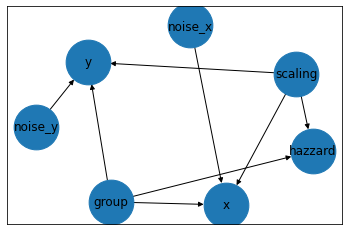

In [114]:
simpson_graph = SimpsonsParadoxGraph()
gnx = simpson_graph.to_networkx()
nx.draw_networkx(
    gnx,
    labels={n: n.name for n in gnx.nodes},
    pos=nx.layout.spring_layout(gnx, k=3),
    node_size=2_000,
)

In [121]:
n_samples = 10_000
data = []
for _ in tqdm.auto.trange(n_samples):
    result = simpson_graph.sample()
    data.append(
        {
            "x": result[simpson_graph.x],
            "y": result[simpson_graph.y],
            "hazzard": float(result[simpson_graph.hazzard]),
            "group": result[simpson_graph.group],
            "scaling": result[simpson_graph.scaling],
        }
    )
df = pd.DataFrame(data)
sim = SimulationModelWithRisk(risk_type='linear',
                                      alpha=1.0,
                                      beta=5.0,
                                      censored_parameter=5.0,
                                      survival_distribution='weibull')
df = sim.generate_data(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of data-points: 10000 - Number of events: 7900.0


In [122]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities'
training_df = df.loc[:, ['x', 'y', 'time', 'event']]
save_orig(training_df, name='simpsons', output_dir=directory)

Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_train.csv
Saved /data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/resample_multiplicities/simpsons_valid.csv


In [123]:
xdf, ydf, df = simpson_graph.get_interventions(simpson_graph, sim, 5000)

Intervention noise_x:   0%|          | 0/5000 [00:00<?, ?it/s]

Intervention noise_y:   0%|          | 0/5000 [00:00<?, ?it/s]

Number of data-points: 10000 - Number of events: 7902.0


In [124]:
xdf.to_csv(f'{directory}/simpsons_attribute_x.csv', index=False)
ydf.to_csv(f'{directory}/simpsons_attribute_y.csv', index=False)
df.to_csv(f'{directory}/simpsons_attribute_details.csv', index=False)